In [3]:
# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt
import seaborn as sns
import torch
# Type hints
from typing import Callable, Union, Tuple

import os
import sys
mac_gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(mac_gems_tco_path)

# Custom imports
from GEMS_TCO import data_preprocess
from GEMS_TCO import kernels 
from GEMS_TCO import evaluate
from GEMS_TCO import load_data
from GEMS_TCO import configuration as config

import pickle
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
import pandas as pd

import matplotlib.transforms as transforms

from pathlib import Path
import json
from json import JSONEncoder

# Summary

We will explore data on an hourly scale. ```The cyclic pattern``` shown in the ```semivariograms``` indicates that we should fit the data with a model that can explain this cyclic pattern.

Secondly, ```asymmetric cross-variograms``` on some days imply that there is ```space and time interaction```, hence we should consider a non-separable model.

Lastly, ```latitude-sliced``` data shows ```spatial non-stationarity```. I plan to ```detrend for 5x10 spatial points``` in the N5N10 E110E120 region.

## Quick load empirical semiovariograms from Amarel

In [5]:
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/df_empirical_semivariograms_and_cv/"

input_filename = "empirical_cross_lat_sem_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    cross_lat_18000= pickle.load(pickle_file)


input_filename = "empirical_cross_lon_sem_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    cross_lon_18000= pickle.load(pickle_file)


input_filename = "empirical_lat_sem_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    emp_lat_18000= pickle.load(pickle_file)


input_filename = "empirical_lon_sem_july24.pkl"
    
input_filepath = os.path.join(input_path, input_filename)
# Load pickle
with open(input_filepath, 'rb') as pickle_file:
    emp_lon_18000= pickle.load(pickle_file)



# smooth 0.5

# load estimates

In [ ]:

data_load_instance = load_data(config.mac_data_load_path)
df = data_load_instance.read_pickle(config.mac_estimates_day_path,config.mac_full_day_v05_pickle)
df.head()

# Empirical and theoretical directional semivariograms

In [9]:
base_path = Path("/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/estimates/df_cv_smooth_05")

#full_day_r2s10_v045_spline1250 = pd.read_csv( base_path / "full_day_r2s10_v045_spline1250.0.csv")
#full_day_r2s10_v055_spline1250 = pd.read_csv( base_path / "full_day_r2s10_v055_spline1250.0.csv")

full_day_v05_r2s10_1127 = pd.read_csv(base_path / "full_day_v05_r2s10_1127.csv")

vecchia_v05_r2s10_1127 = pd.read_csv( base_path / "vecchia_v05_r2s10_1127.csv")
vecchia_v05_r2s10_4508 = pd.read_csv( base_path / "vecchia_v05_r2s10_4508.csv")
vecchia_v05_r2s10_18033 = pd.read_csv( base_path / "vecchia_v05_r2s10_18033.csv")

In [10]:
print(f'v0.5 full likelihood 1127:\n{full_day_v05_r2s10_1127.iloc[:,5:-2].head(6)}')
print(f'v0.5 vecchia 1127:\n{vecchia_v05_r2s10_1127.iloc[:,5:-2].head(6)}')
print(f'v0.5 vecchia 4508:\n{vecchia_v05_r2s10_4508.iloc[:,5:-2].head(6)}')
print(f'v0.5 vecchia 18033:\n{vecchia_v05_r2s10_18033.iloc[:,5:-2].head(6)}')

v0.5 full likelihood 1127:
    sigma  range_lat  range_lon  advec_lat  advec_lon   beta  nugget  \
0  20.899      1.040      1.337      0.040     -0.178  0.195   4.498   
1  21.489      1.442      1.716     -0.016     -0.257  0.137   3.261   
2  29.135      0.684      0.960     -0.039     -0.250  0.210   4.668   
3  26.559      1.552      2.091     -0.001     -0.123  0.107   4.776   
4  23.333      0.730      1.328      0.070     -0.232  0.176   4.199   
5  19.829      1.059      2.315      0.045     -0.325  0.153   5.822   

        loss  
0  14625.690  
1  14196.832  
2  16045.347  
3  13960.947  
4  14970.072  
5  15056.543  
v0.5 vecchia 1127:
    sigma  range_lat  range_lon  advec_lat  advec_lon   beta  nugget  \
0  21.303      1.307      1.563      0.022     -0.144  0.198   4.769   
1  21.674      1.265      1.447      0.004     -0.175  0.223   3.555   
2  29.484      0.758      0.876     -0.071     -0.237  0.223   4.968   
3  27.378      2.119      3.067     -0.014     -0.061  0

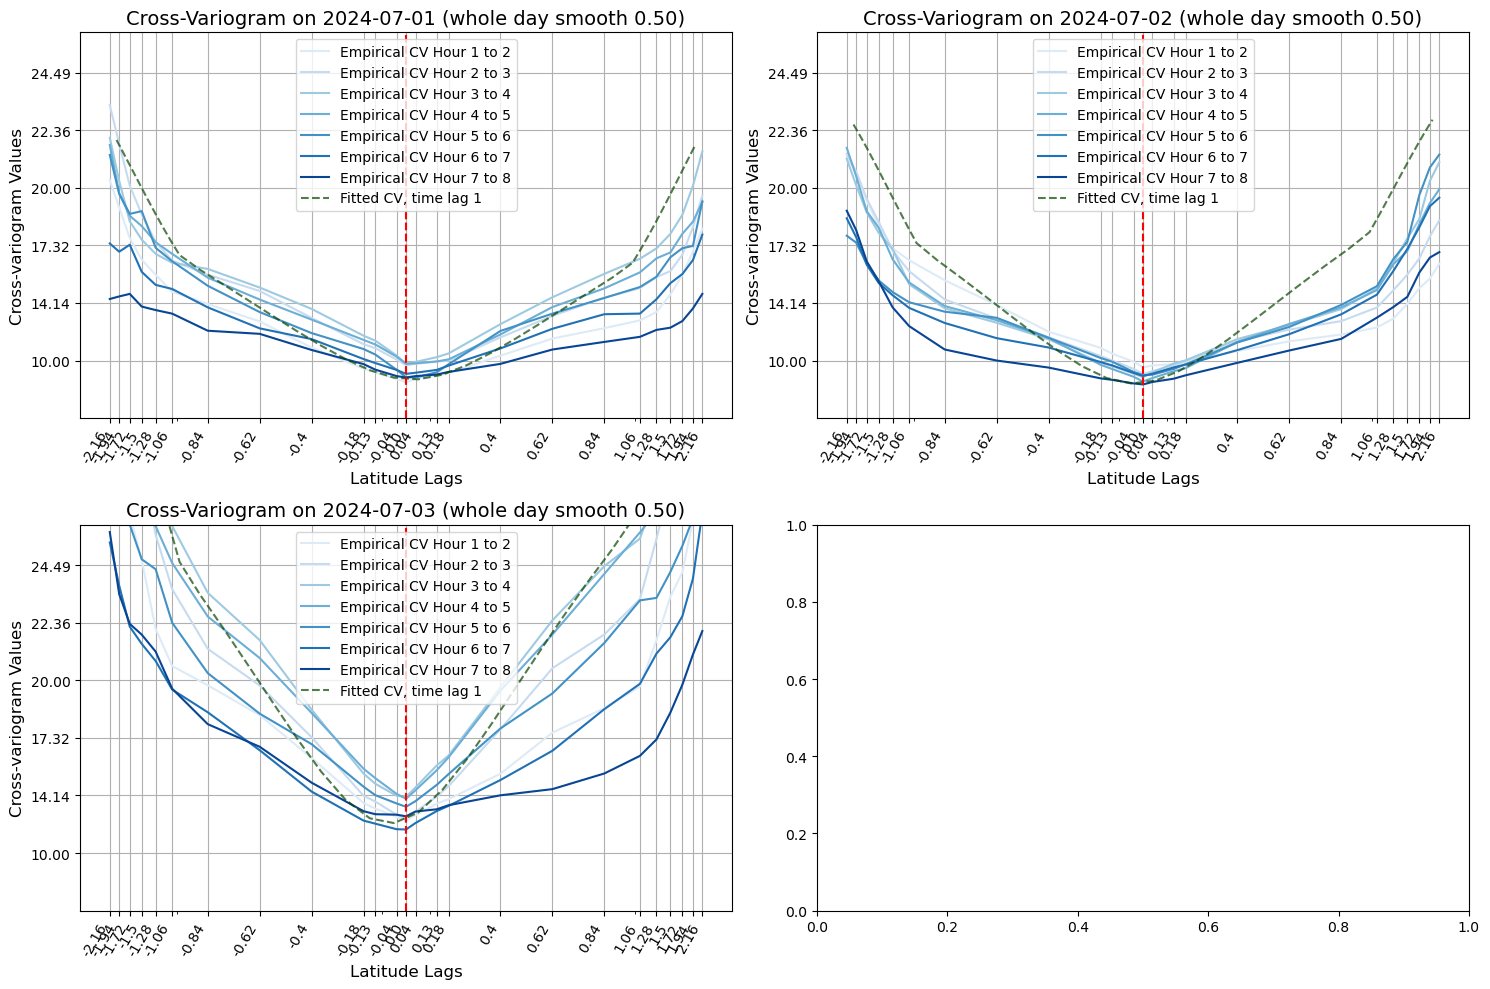

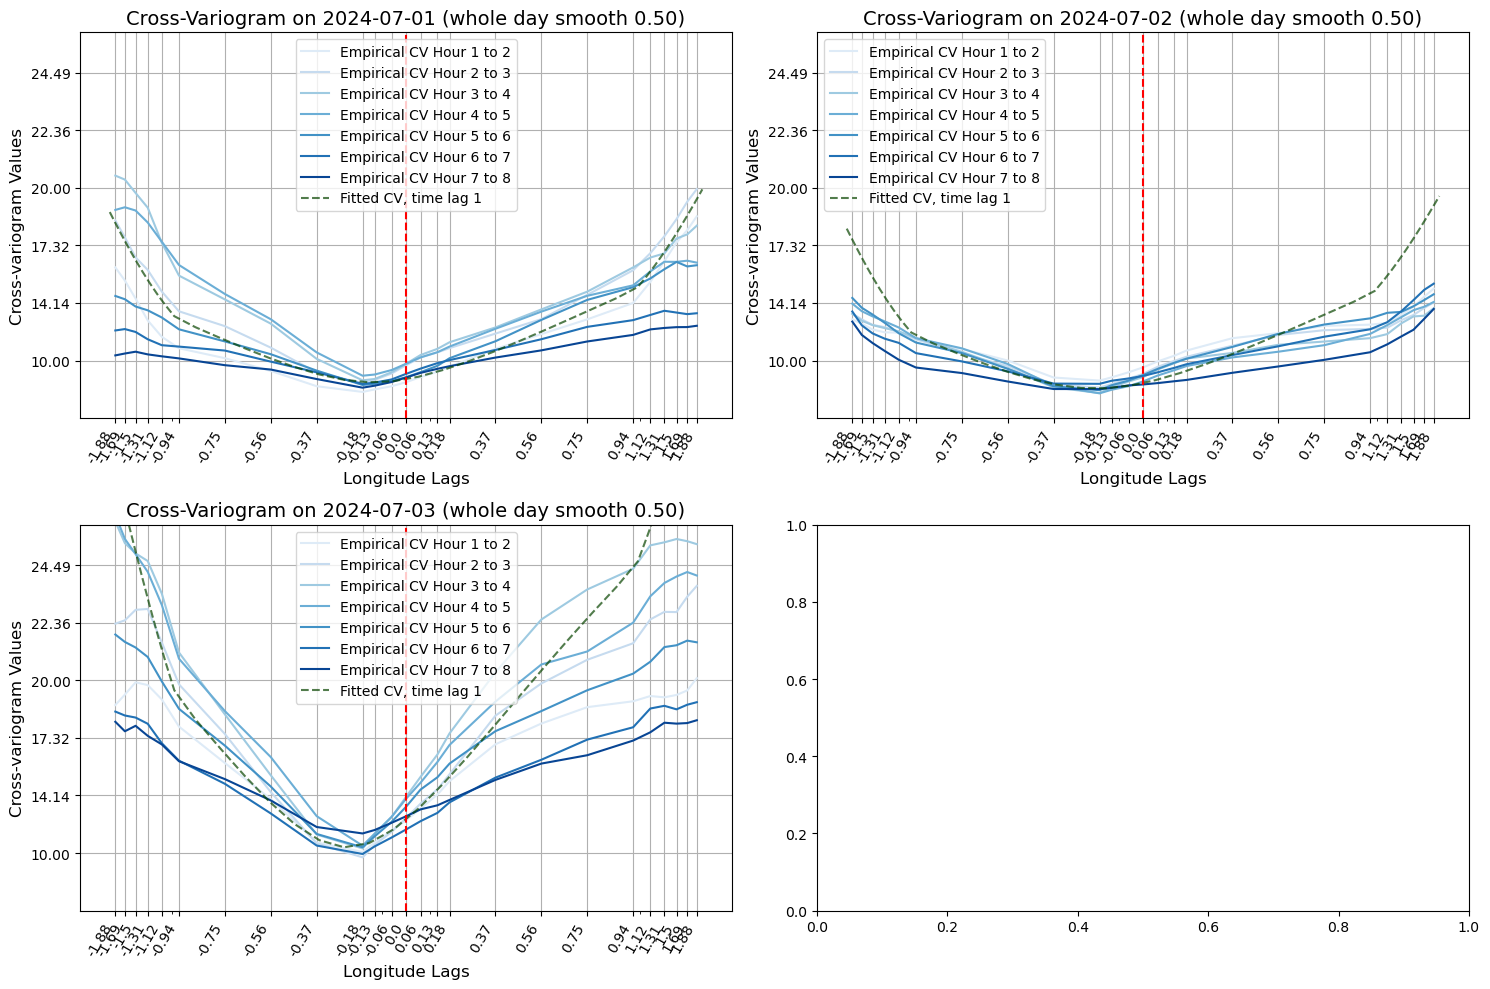

In [16]:
save_path = config.mac_save_semivariogram_path
save_path = Path("/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/plots/tmp_save")
smooth = 0.5
length_of_analysis = f'whole day smooth {smooth:0.2f}'
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)


#estimates_df= vecchia_v05_r2s10_1127
estimates_df= vecchia_v05_r2s10_4508
#estimates_df= vecchia_v05_r2s10_18033.iloc[:19]

#estimates_df = full_day_r2s10_v045_spline1250
#estimates_df = full_day_r2s10_v055_spline1250
#estimates_df = full_day_v05_r2s10_1127

estimates_df = estimates_df.iloc[:,5:13]
#estimates_df.iloc[0] = [20.934, 2.342, 3.27,  0.016,  -0.098, 0.091, 4.672, 54720]  # vecc spline 0.4
#estimates_df.iloc[1] = [21.48,  2.287, 3.516, -0.03,  -0.147, 0.095, 3.431, 55281]
#estimates_df.iloc[2] = [29.32,  2.284, 2.879, -0.064, -0.205, 0.09,  5.077, 60790]
# estimates_df.iloc[0] = [21.258, 5.93, 5.837, -0.88, 0.884, 0.78, 5.192, 57585] # ridiculus  # vecc 0.4

date_range = pd.date_range(start='07-01-24', end='07-31-24')
#date_range = pd.date_range(start='07-01-24', end='07-19-24')
estimates_df.index = date_range


# dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]
dayss = [[1,2,3]]

tmp_lat = cross_lat_18000[0]
tmp_lon = cross_lon_18000[0]
for days in dayss:
    
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a[0],2), 0 ) for a in tmp_lat]
    instance_sem.plot_cross_lat_emp_the( cross_lat_18000, days, lat_lags, estimates_df, instance_sem.theoretical_gamma_kv)

    # longitude direction
    lon_lags = [ (0, round(a[1], 2)) for a in tmp_lon]
    instance_sem.plot_cross_lon_emp_the( cross_lon_18000,days,lon_lags, estimates_df, instance_sem.theoretical_gamma_kv)



# smooth 1.0

In [ ]:
save_path = config.mac_save_semivariogram_path
smooth = 1.0
length_of_analysis = f'whole day smooth {smooth:0.1f}'
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)

input_filename = "full_day_v10_spline1250.0.csv"
input_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/Exercises/st_model/estimates"
input_filepath = os.path.join(input_path, input_filename)
df_full_v10 = pd.read_csv(input_filepath)  
df_full_v10 = df_full_v10.iloc[:,5:13]  

date_range = pd.date_range(start='07-01-24', end='07-31-24')
df_full_v10.index = date_range

df_full_v10


In [ ]:
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]

dayss = [[ 1,3,4]]
# df_full_v10.iloc[0] = [12.8, 0.38,0.488, 0.028, -0.155, 0.591, 2.681, 500 ]
df_full_v10.iloc[0] = [26.142, 0.79,0.853, 0.0004, -0.114, 0.269, 4.337, 500 ]
# df_full_v10.iloc[3] = [25.8, 0.797, 2.668, -0.050, -0.207, 0.301, 4.116, 500 ]

for days in dayss:
    tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_emp_the( d_lat_20000,days, lat_lags, df_full_v10, instance_sem.theoretical_gamma_kv)
 
    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_emp_the( d_lon_20000,days,lon_lags, df_full_v10,  instance_sem.theoretical_gamma_kv)



# smooth 1.5 

# empirical semivariogram and variances

This can help decide which model has better estimates of nuggets. If the estimated nuggets are too off from the extrapolation of first three shortest lag semiovariograms, then that might be the sign of model misspecification. 

In [6]:
day = 1
hour = 0
days = [13,1,4,18]

days = list(range(1,32))
for day in days:
    lat_lon_resolution = [1,1]
    mm_cond_number = 20

    # input_path = Path("C:\\Users\\joonw\\tco\\Extracted_data")  # window
    input_path = Path("/Users/joonwonlee/Documents/GEMS_DATA")
    instance = load_data(input_path)

    years = ['2024']
    month_range =[7,8]
    idx_for_datamap= [ 8*(day-1),8*day]

    map, ord_mm, nns_map= instance.load_mm20k_data_bymonthyear( lat_lon_resolution= lat_lon_resolution, mm_cond_number=mm_cond_number,years_=years, months_=month_range)
    analysis_data_map, aggregated_data = instance.load_working_data_byday( map, ord_mm, nns_map, idx_for_datamap= idx_for_datamap)

    keys = list(analysis_data_map.keys())
 
    # print(f' The variance of ozone on day {day}, hour {hour+1}: {torch.var(analysis_data_map[keys[hour]][:,2])}')
    print(f' The averaged variance of ozone on day {day}, : {torch.var(aggregated_data[:,2])}')

    # print(f'Sorted semivariograms on day {day}, hour {hour+1} : {sorted(d_lon_20000[day][hour])}')

 The averaged variance of ozone on day 1, : 18.093228483905158
 The averaged variance of ozone on day 2, : 19.830077847374998
 The averaged variance of ozone on day 3, : 26.201912329513327
 The averaged variance of ozone on day 4, : 24.213578782312116
 The averaged variance of ozone on day 5, : 21.06035764854541
 The averaged variance of ozone on day 6, : 17.470533942610555
 The averaged variance of ozone on day 7, : 21.006205005269855
 The averaged variance of ozone on day 8, : 19.323714062462347
 The averaged variance of ozone on day 9, : 12.928196209584216
 The averaged variance of ozone on day 10, : 10.491197135237174
 The averaged variance of ozone on day 11, : 17.4107085243295
 The averaged variance of ozone on day 12, : 17.14961140215415
 The averaged variance of ozone on day 13, : 21.035028247402856
 The averaged variance of ozone on day 14, : 21.839495885019037
 The averaged variance of ozone on day 15, : 24.474136930639748
 The averaged variance of ozone on day 16, : 35.45345

## V15 1180

In [22]:
base_path = Path("/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/estimates/df_cv_smooth_15")

vecchia_v15_r2s10_1127 = pd.read_csv( base_path / "vecchia_v150_r2s10_1127.csv")
vecchia_v15_r2s10_4508 = pd.read_csv( base_path / "vecchia_v150_r2s10_4508.csv")
vecchia_v15_r2s10_18033 = pd.read_csv( base_path / "vecchia_v150_r2s10_18033.csv")

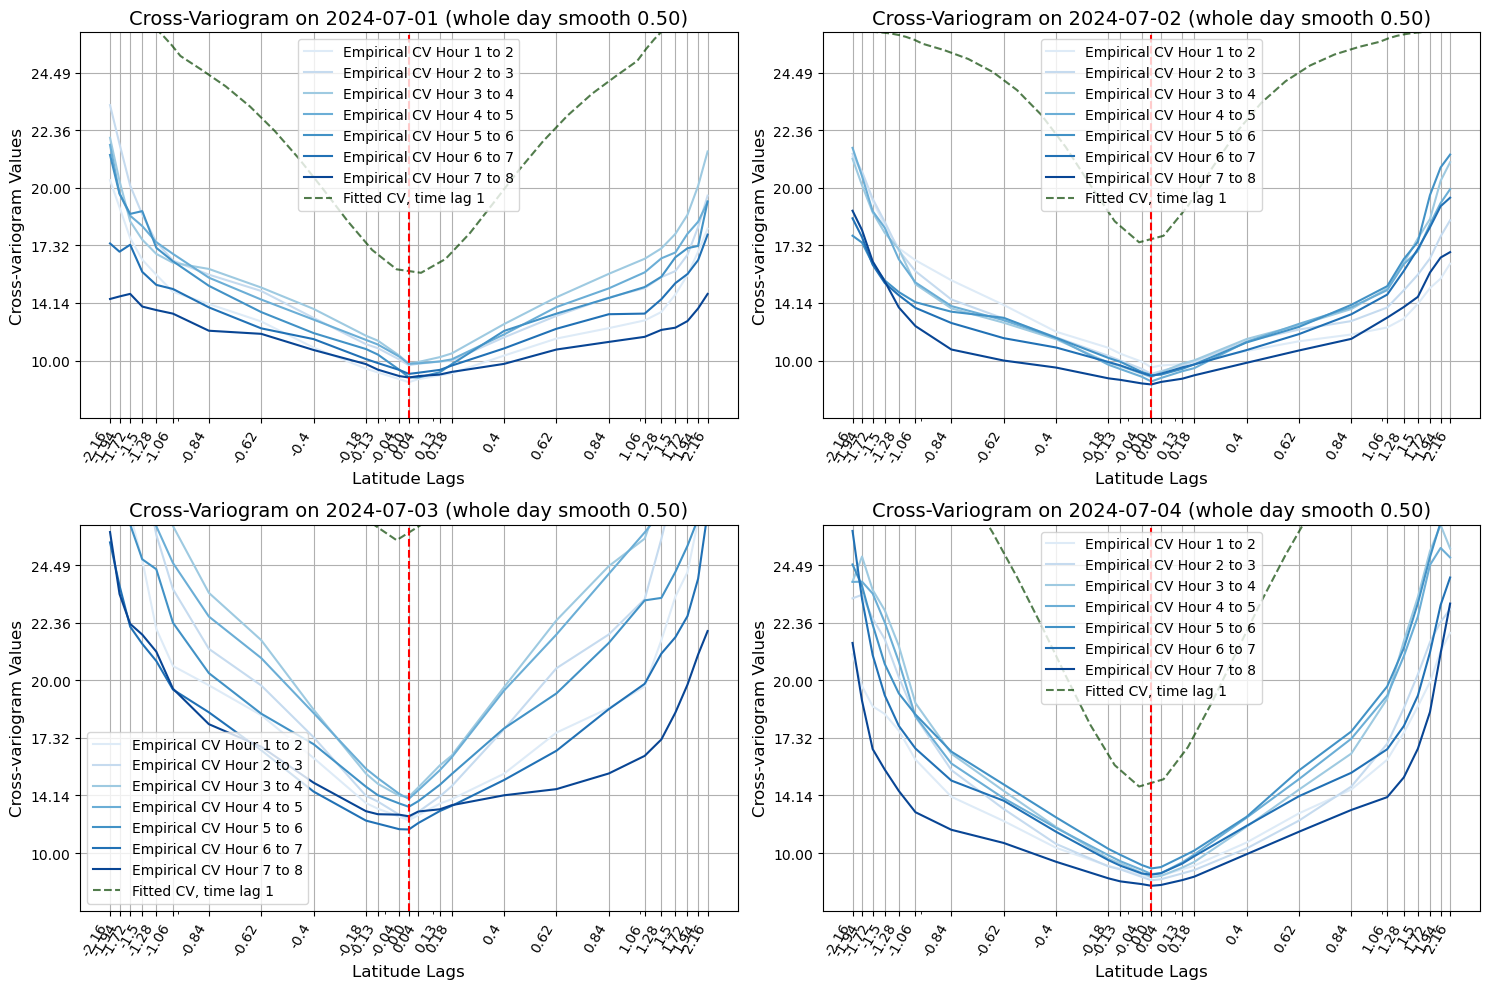

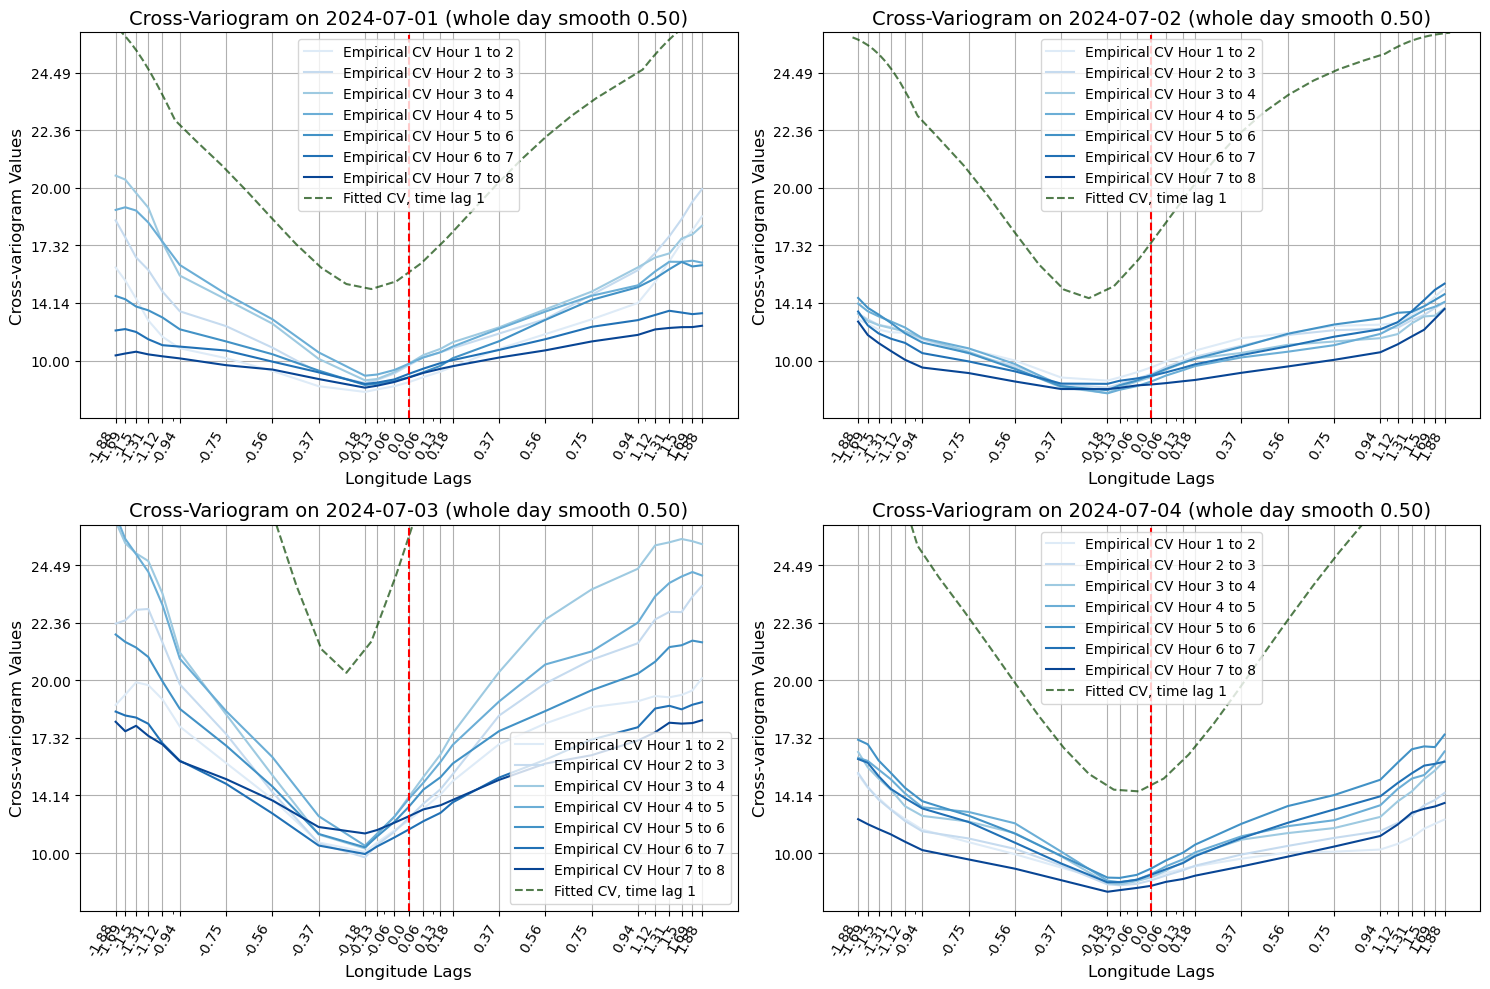

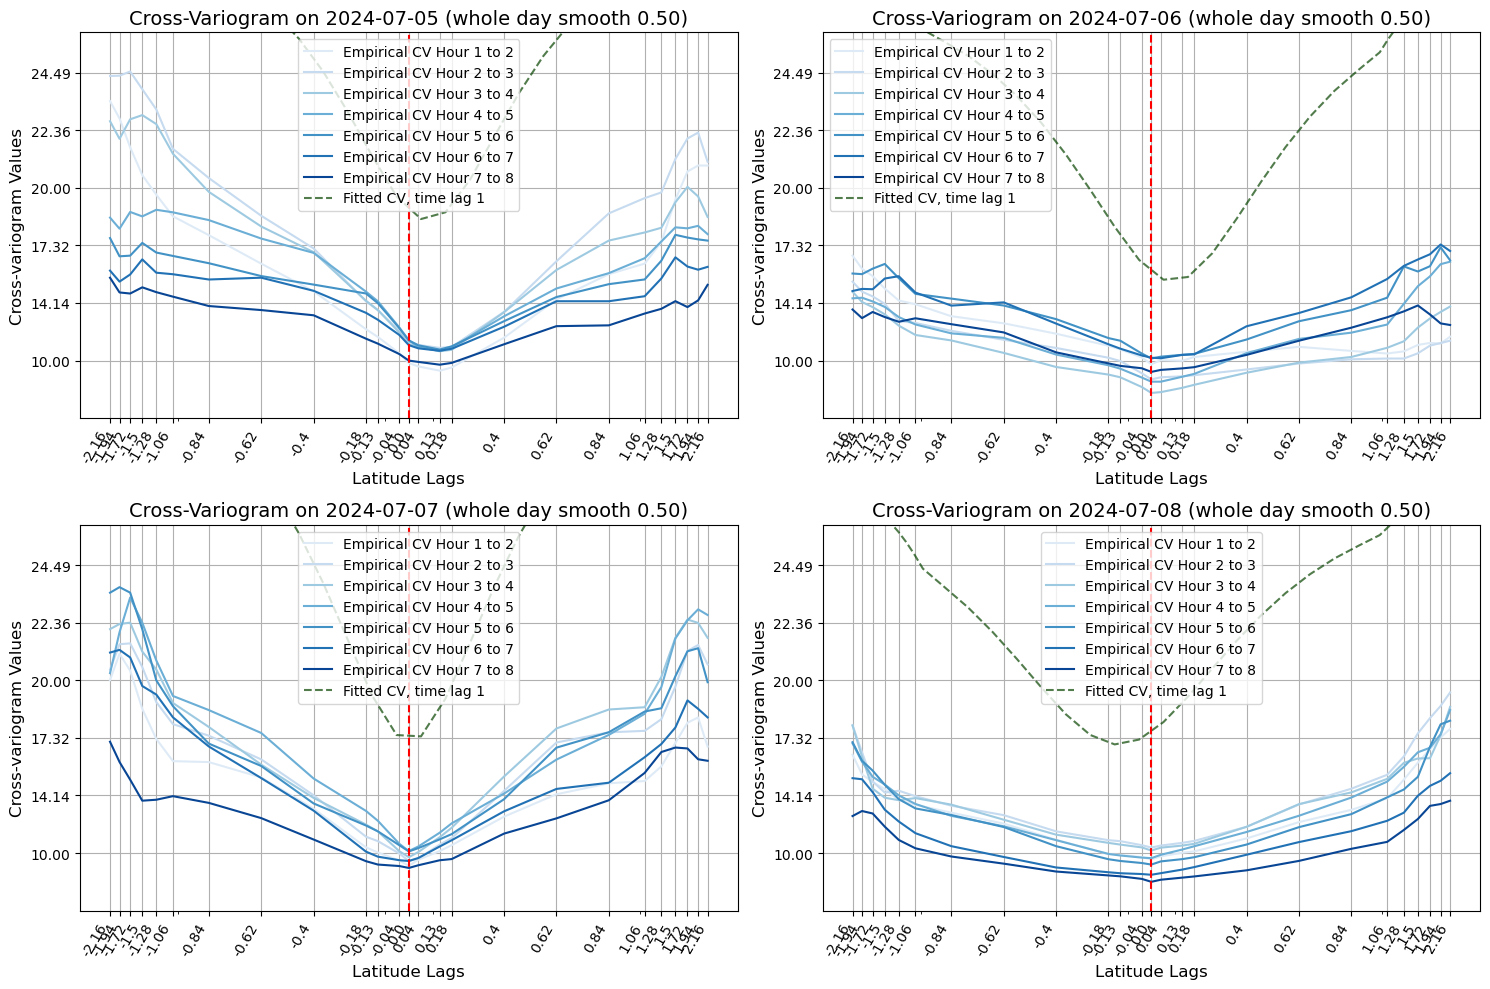

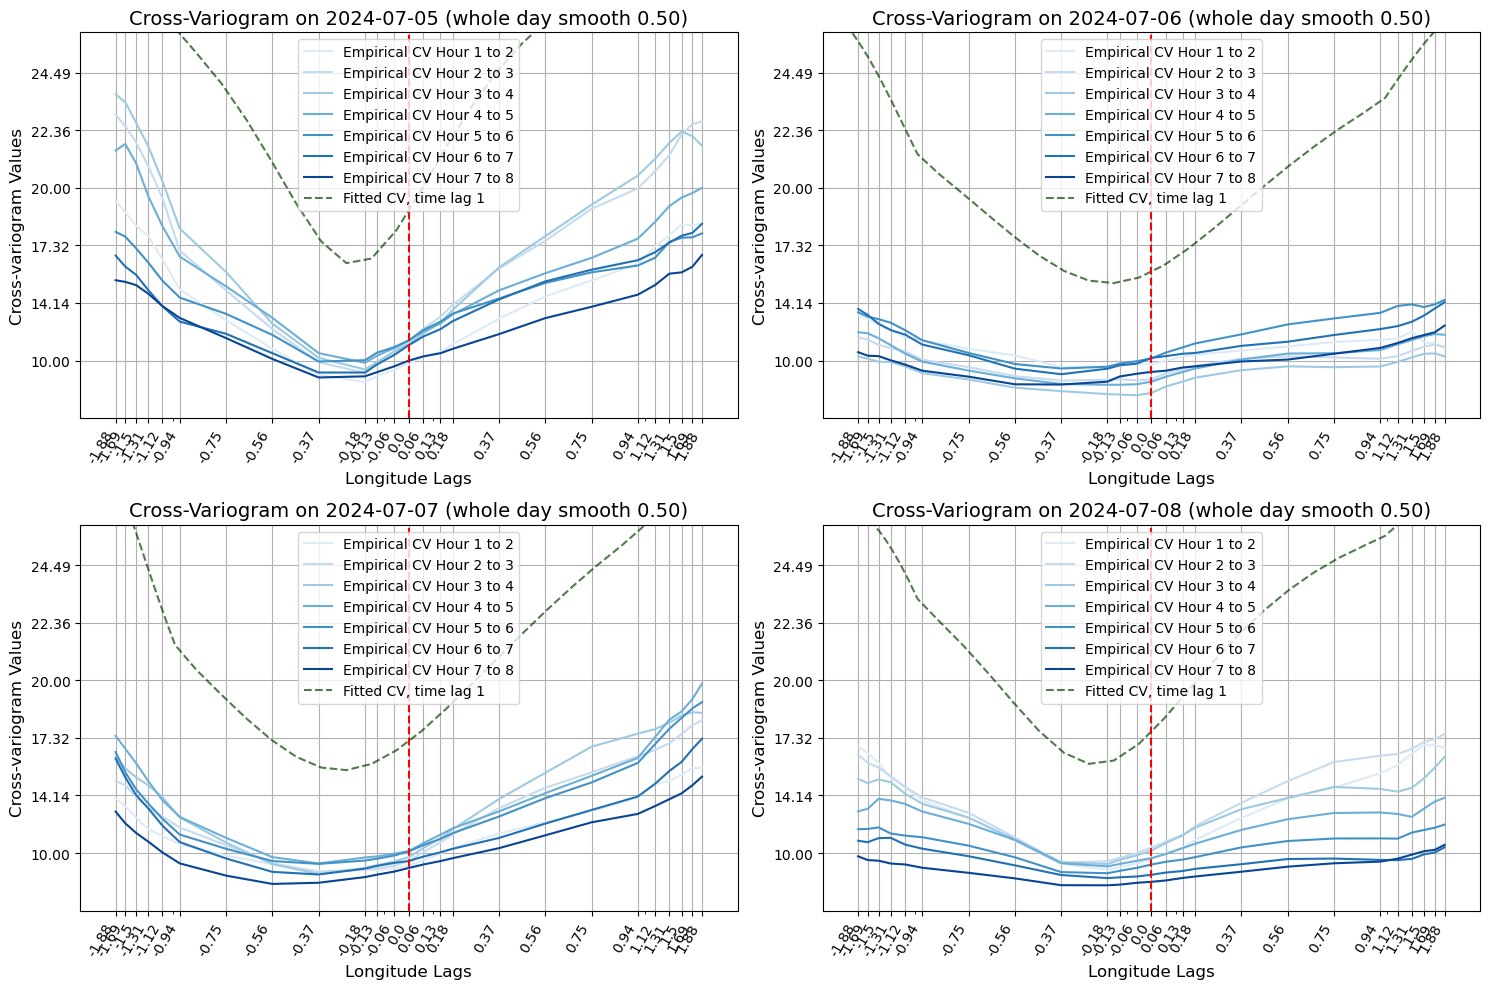

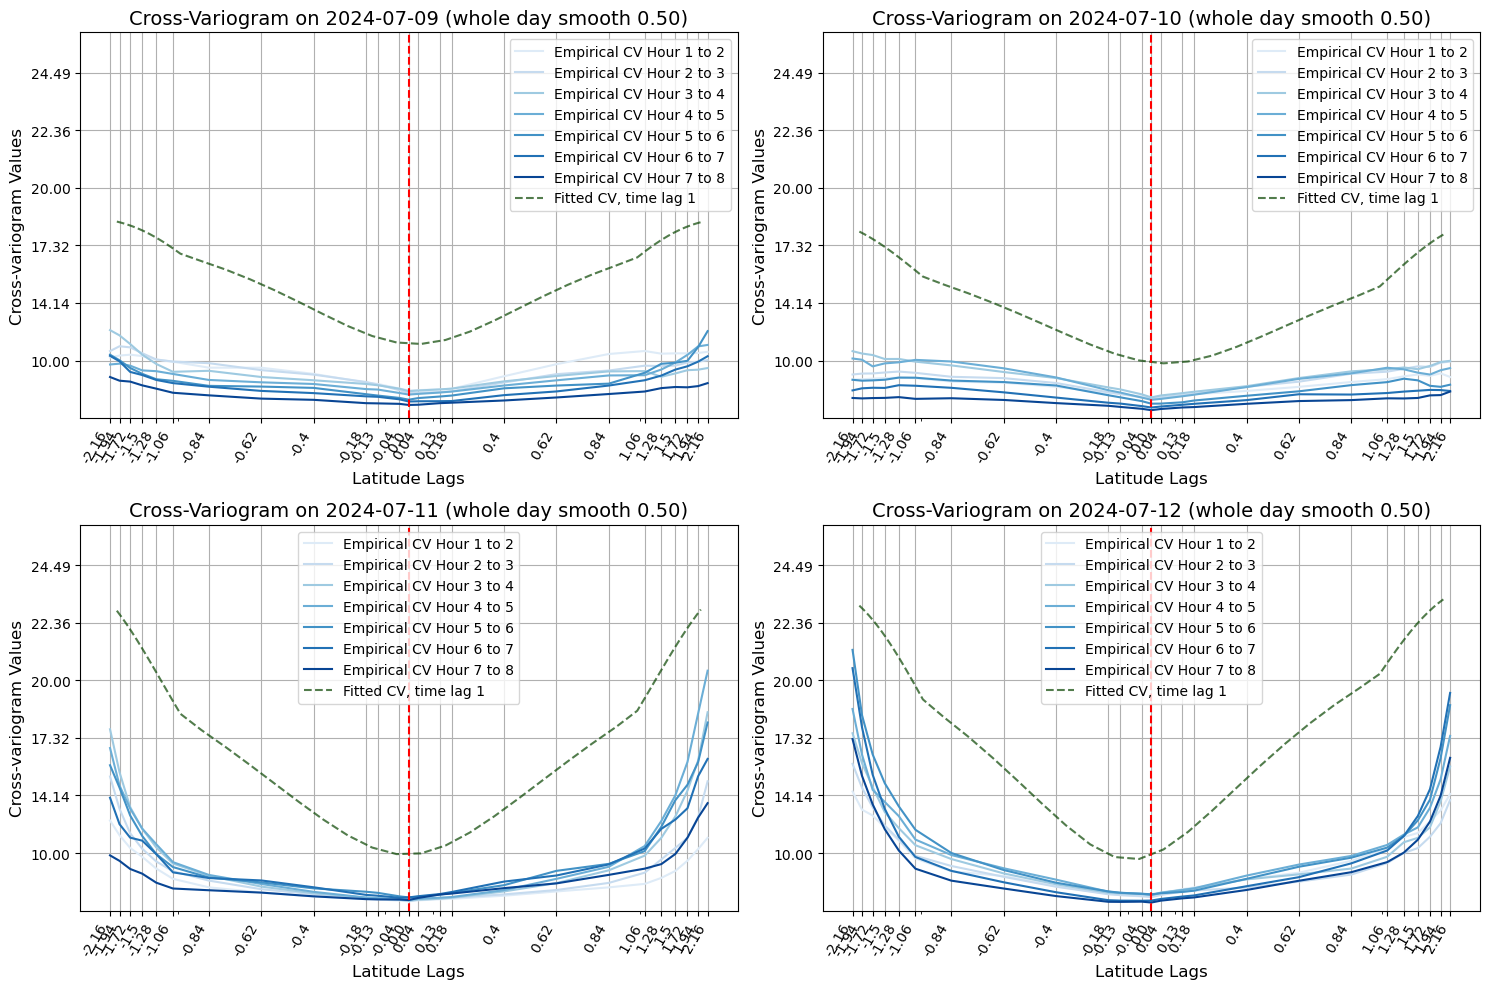

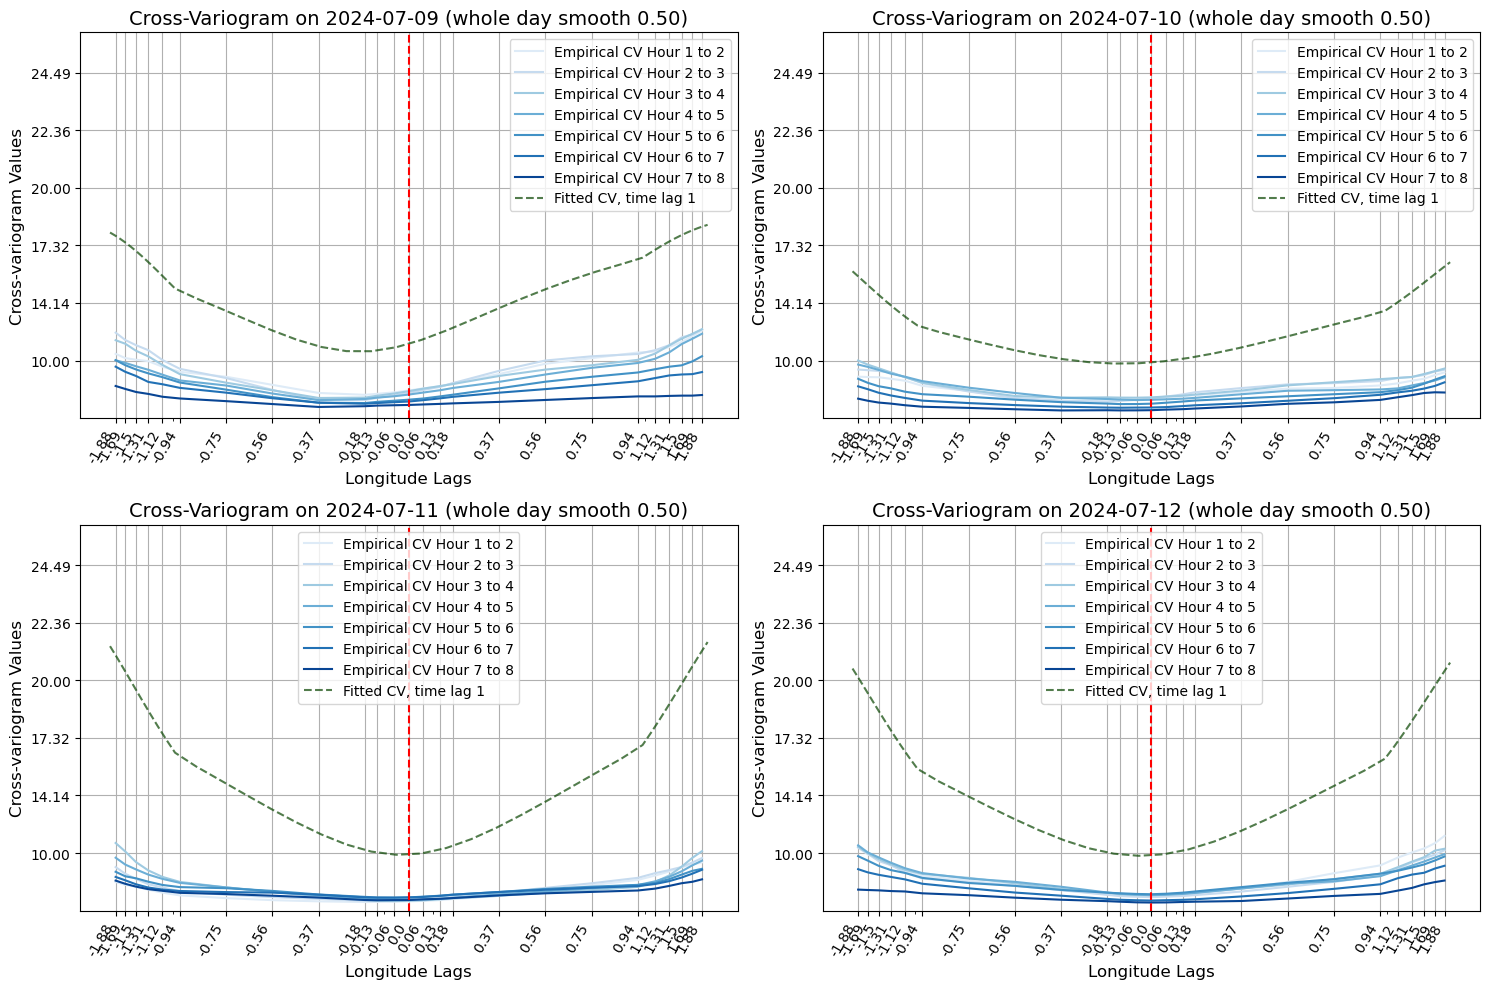

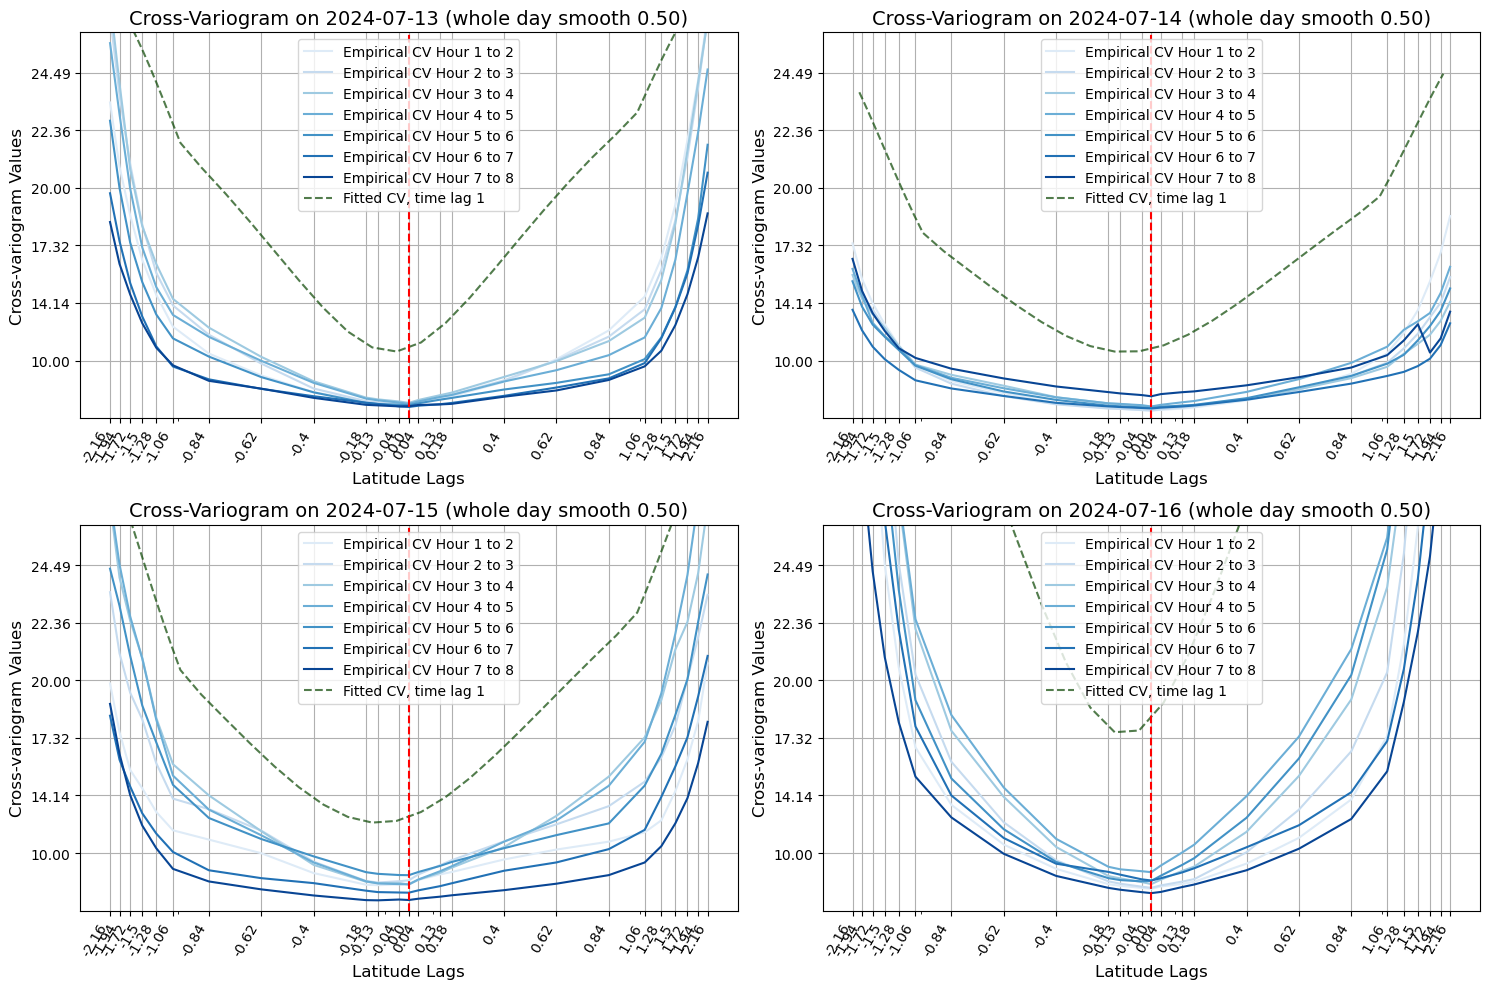

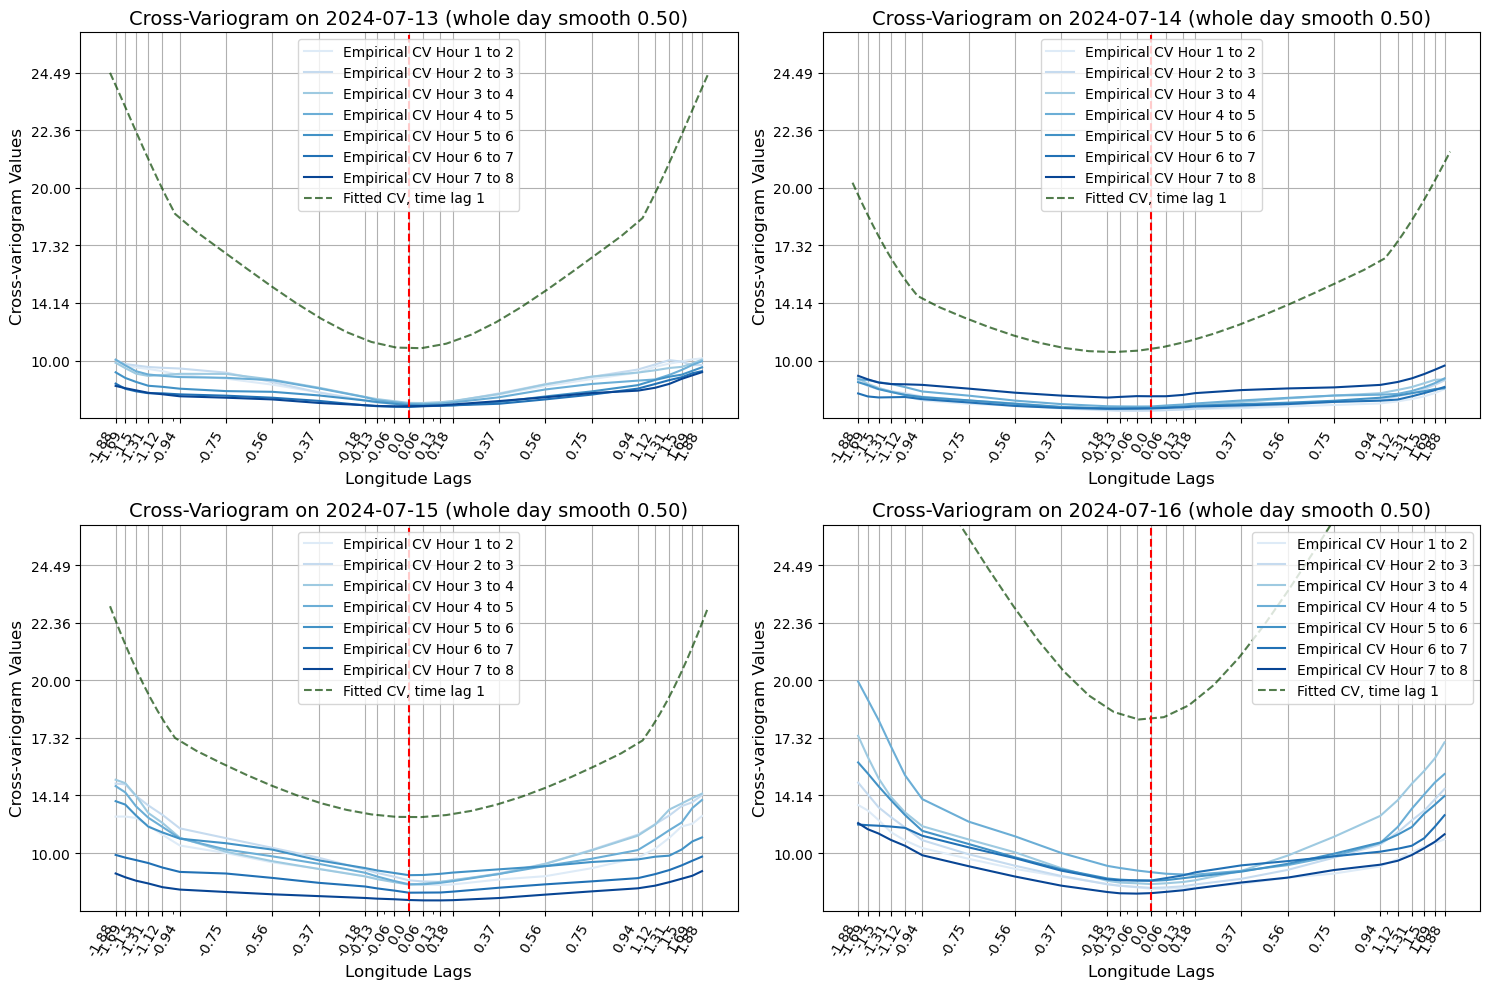

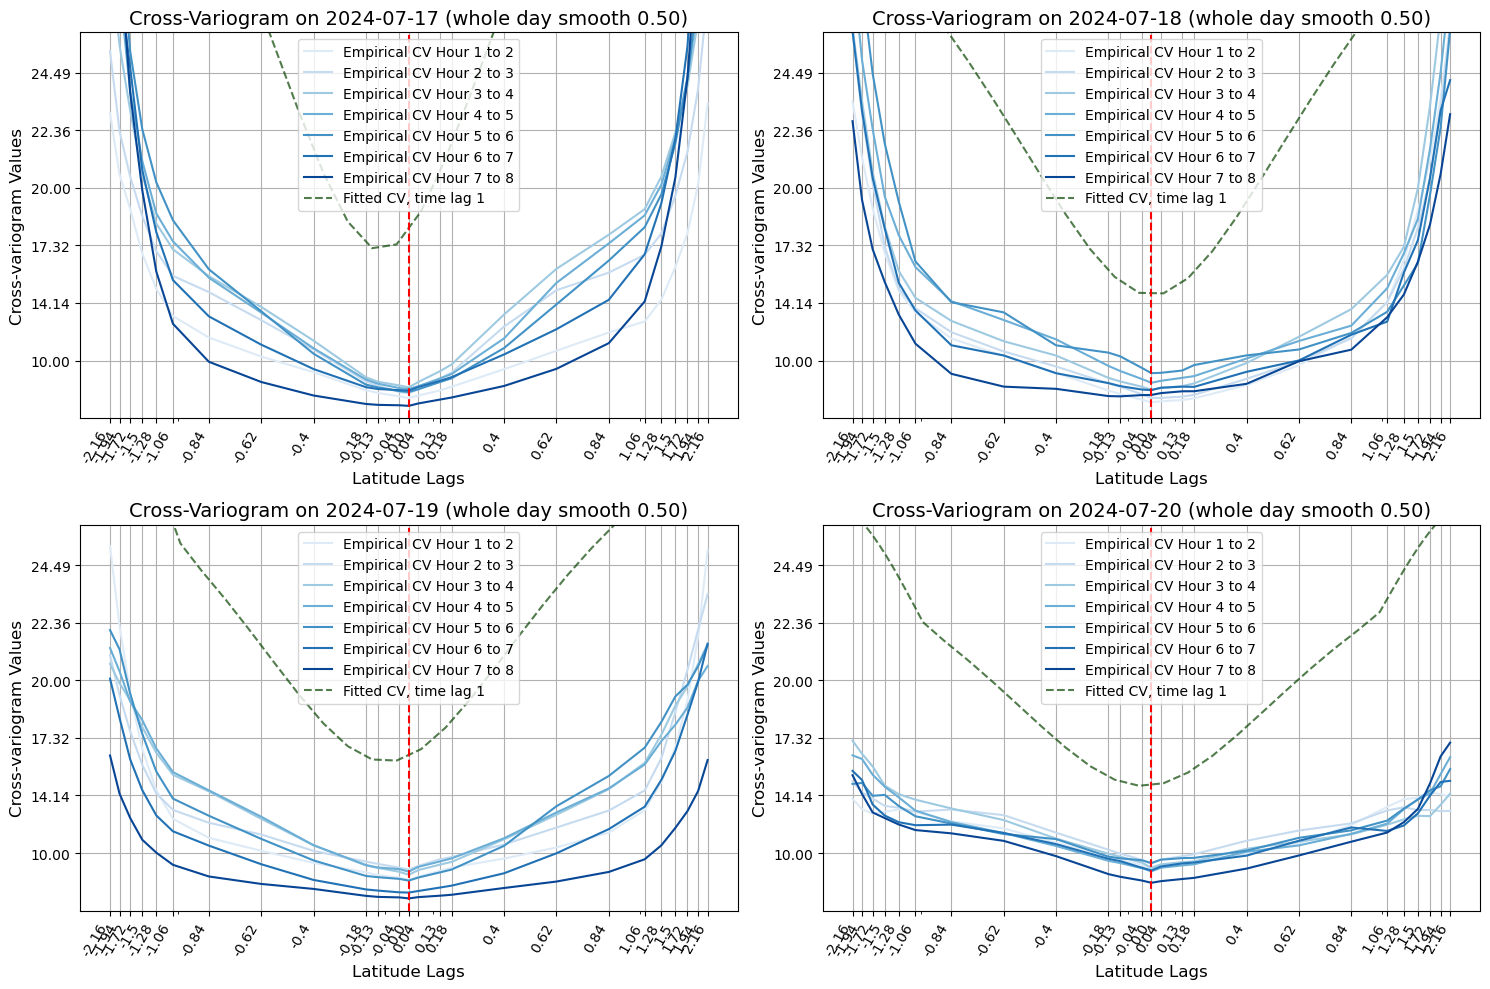

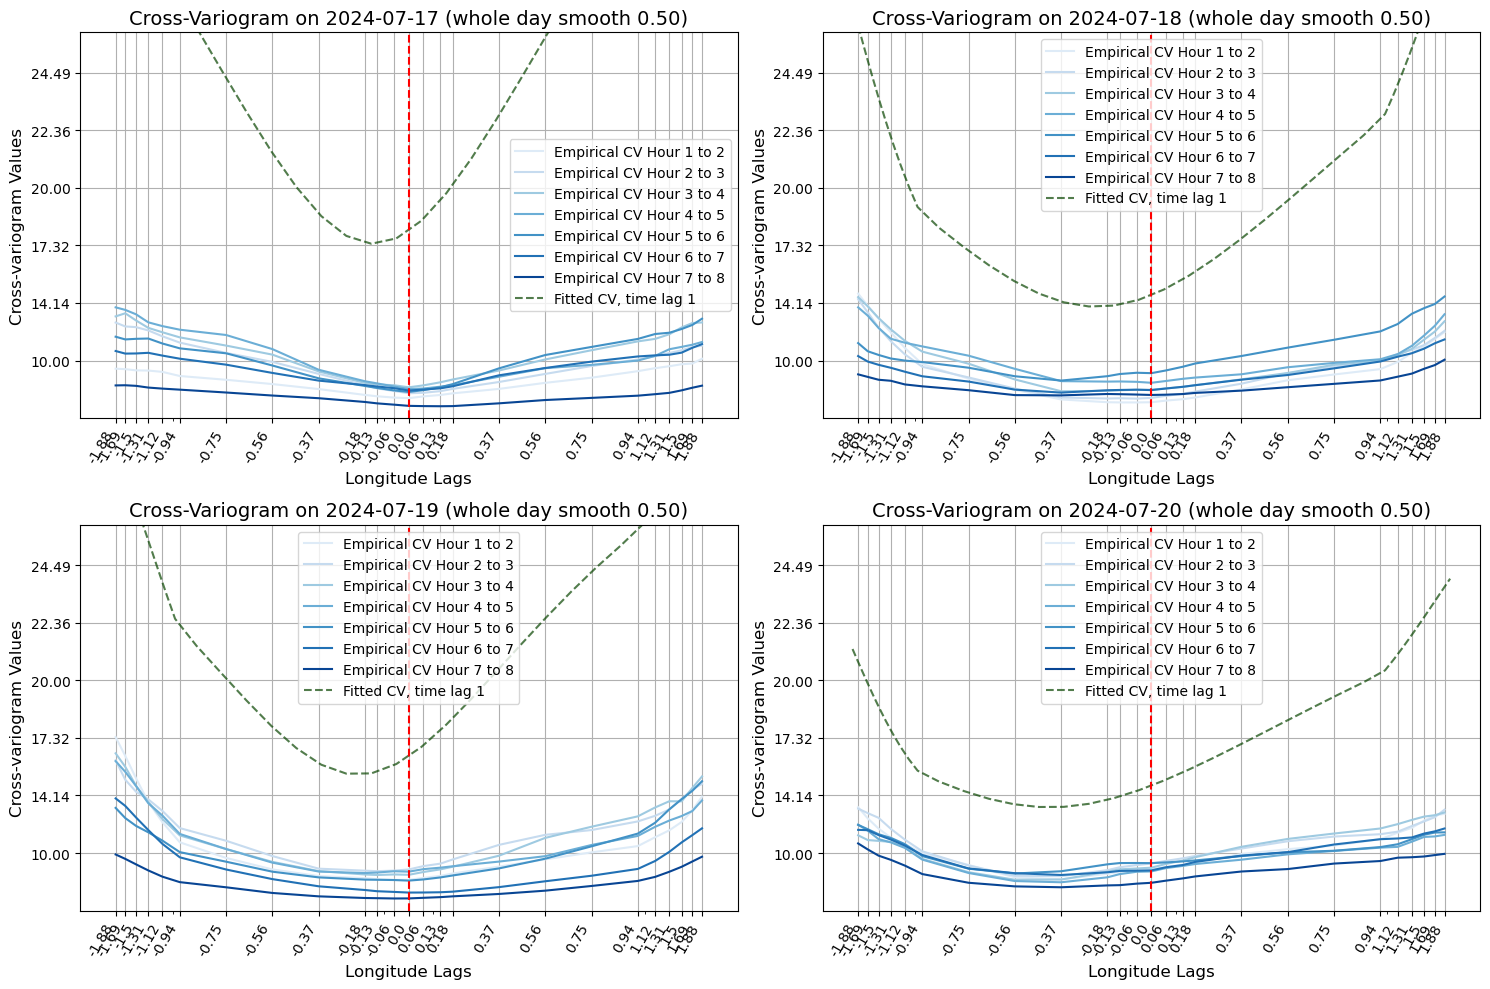

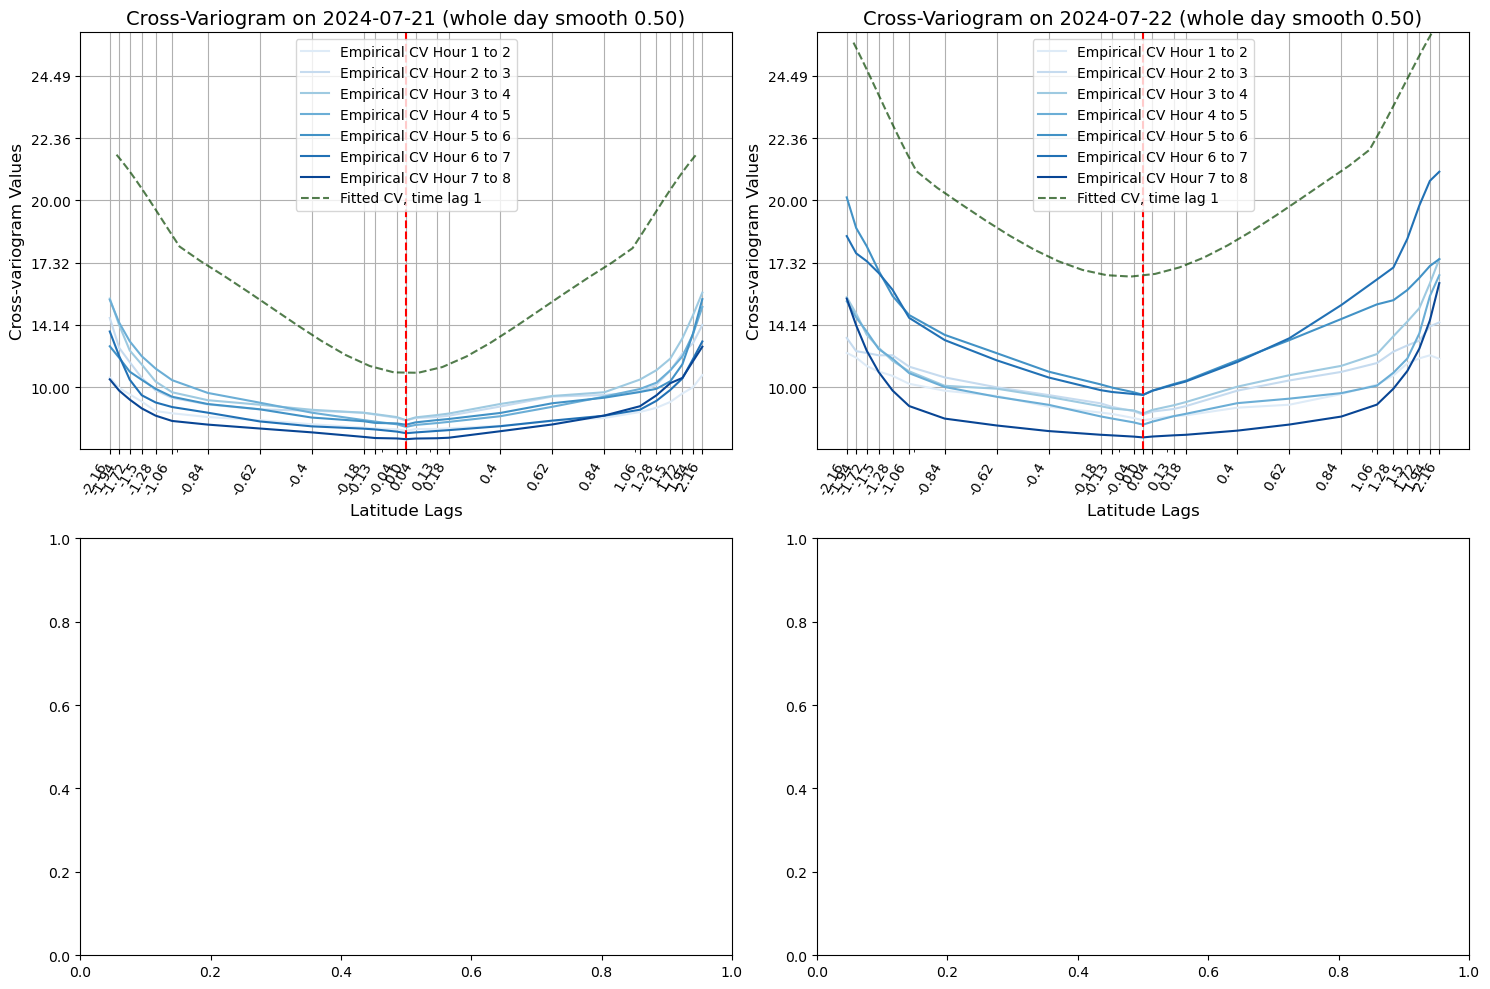

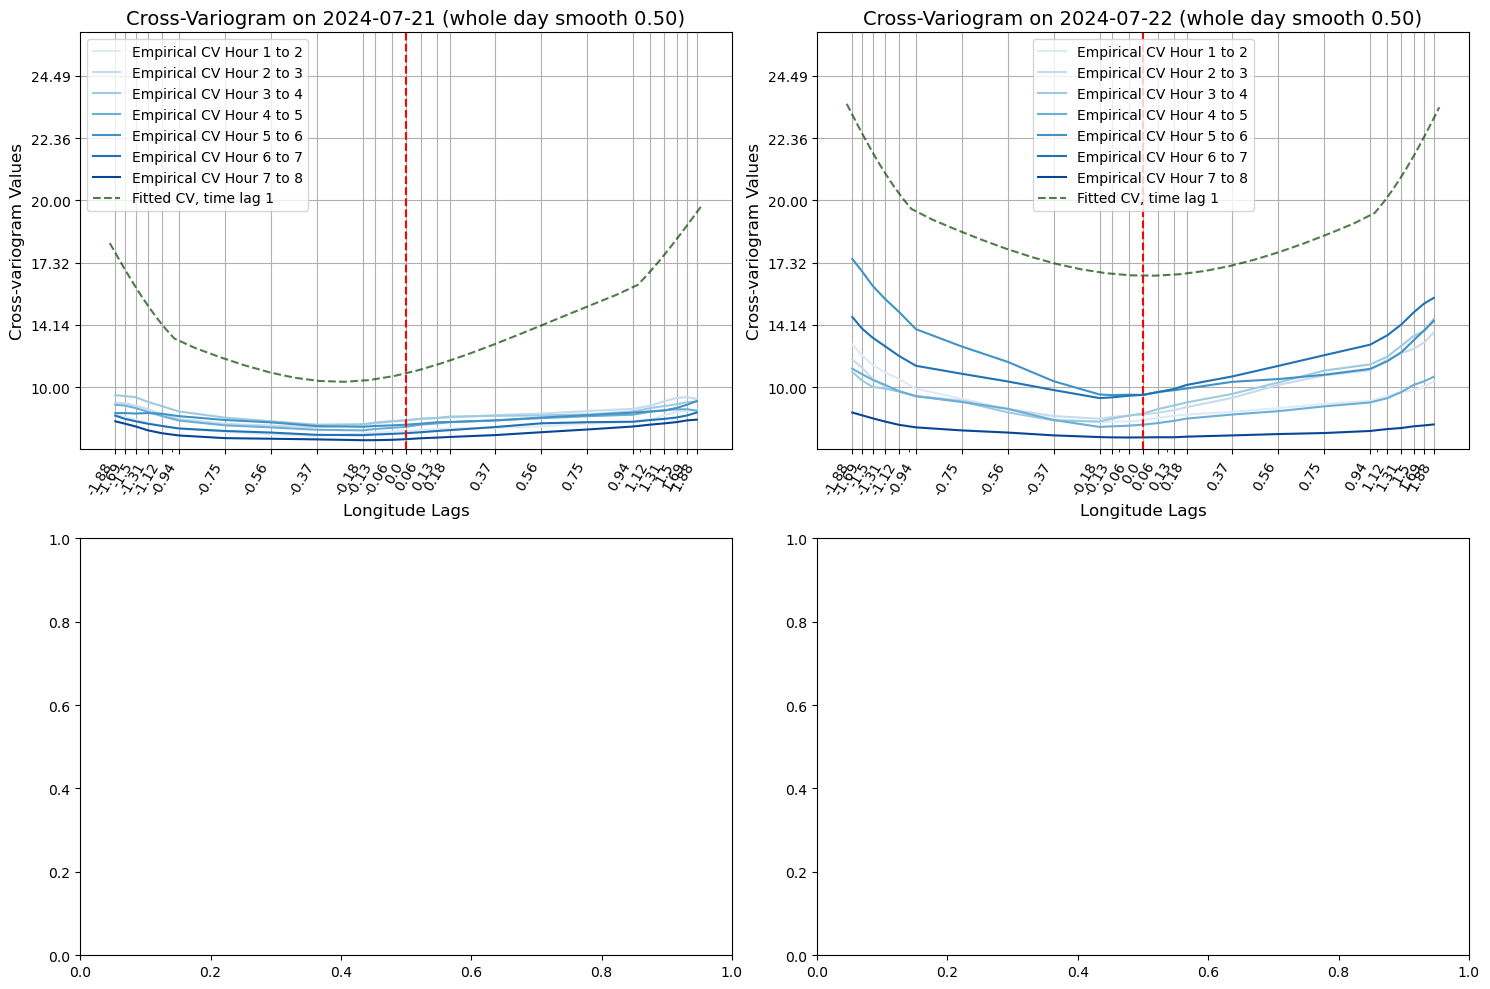

In [24]:
save_path = config.mac_save_semivariogram_path
save_path = Path("/Users/joonwonlee/Documents/GEMS_TCO-1/outputs/day/plots/tmp_save")
smooth = 0.5
length_of_analysis = f'whole day smooth {smooth:0.2f}'
instance_sem = evaluate.CrossVariogram_emp_theory(save_path, length_of_analysis,smooth)


#estimates_df= vecchia_v150_r2s10_1127
#estimates_df= vecchia_v15_r2s10_4508
estimates_df = vecchia_v15_r2s10_18033

estimates_df = estimates_df.iloc[:,5:13]

#date_range = pd.date_range(start='07-01-24', end='07-31-24')
date_range = pd.date_range(start='07-01-24', end='07-22-24')
estimates_df.index = date_range

#dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22]]
#dayss = [[1,2,3]]

tmp_lat = cross_lat_18000[0]
tmp_lon = cross_lon_18000[0]
for days in dayss:
    
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a[0],2), 0 ) for a in tmp_lat]
    instance_sem.plot_cross_lat_emp_the( cross_lat_18000, days, lat_lags, estimates_df, instance_sem.theoretical_gamma_kv)

    # longitude direction
    lon_lags = [ (0, round(a[1], 2)) for a in tmp_lon]
    instance_sem.plot_cross_lon_emp_the( cross_lon_18000,days,lon_lags, estimates_df, instance_sem.theoretical_gamma_kv)


# Empirical cross variograms without theoretical counterparts.

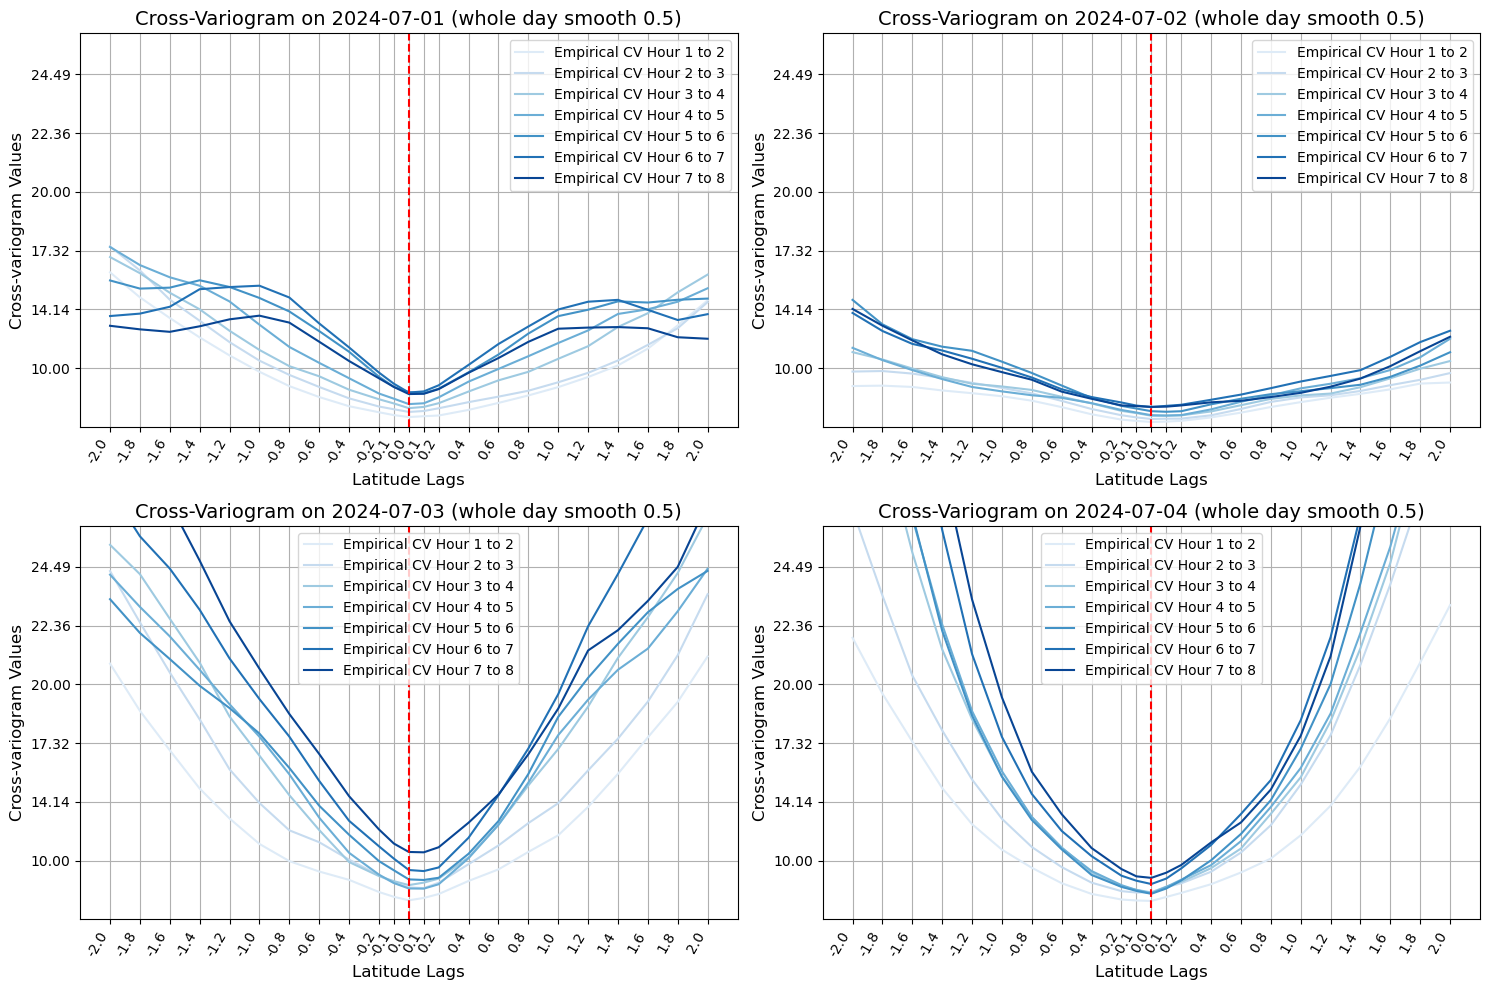

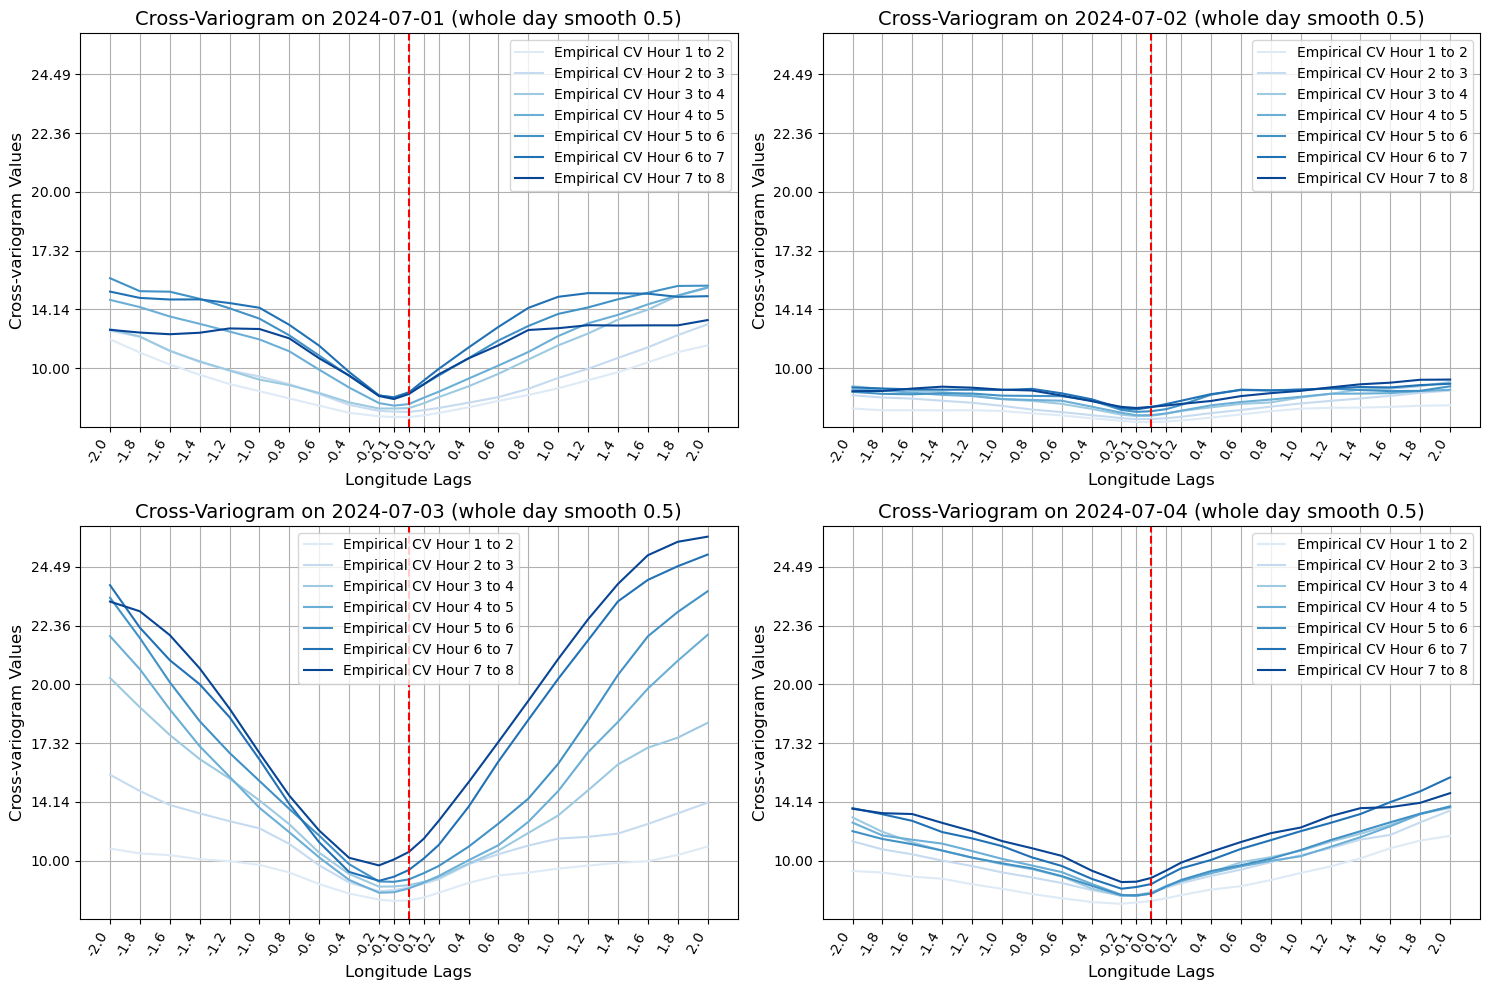

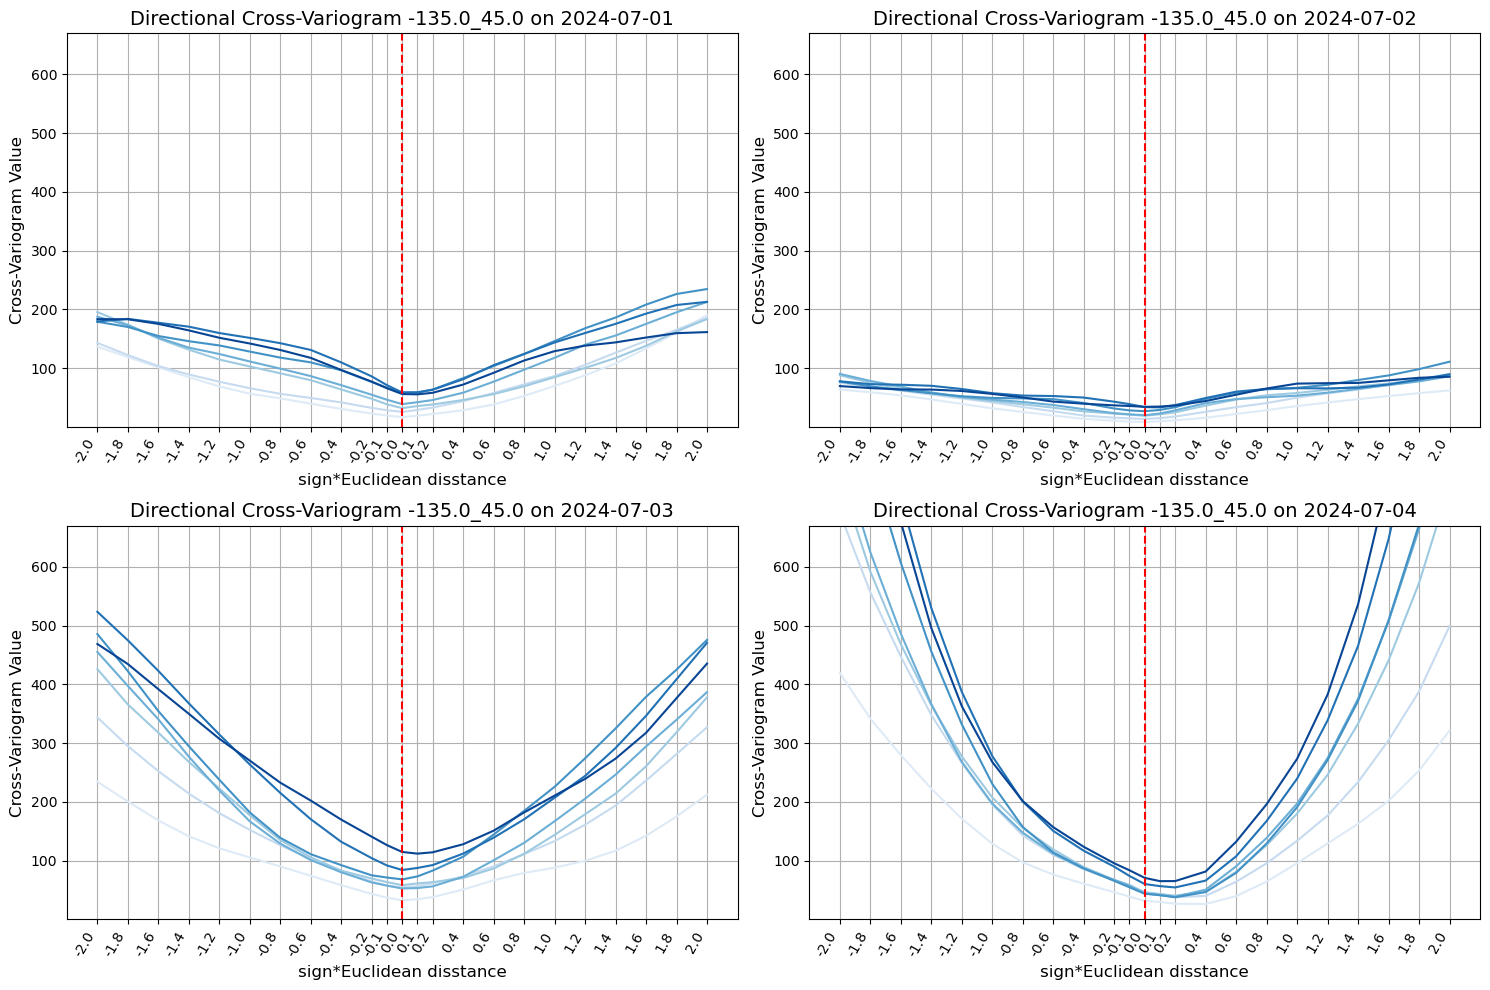

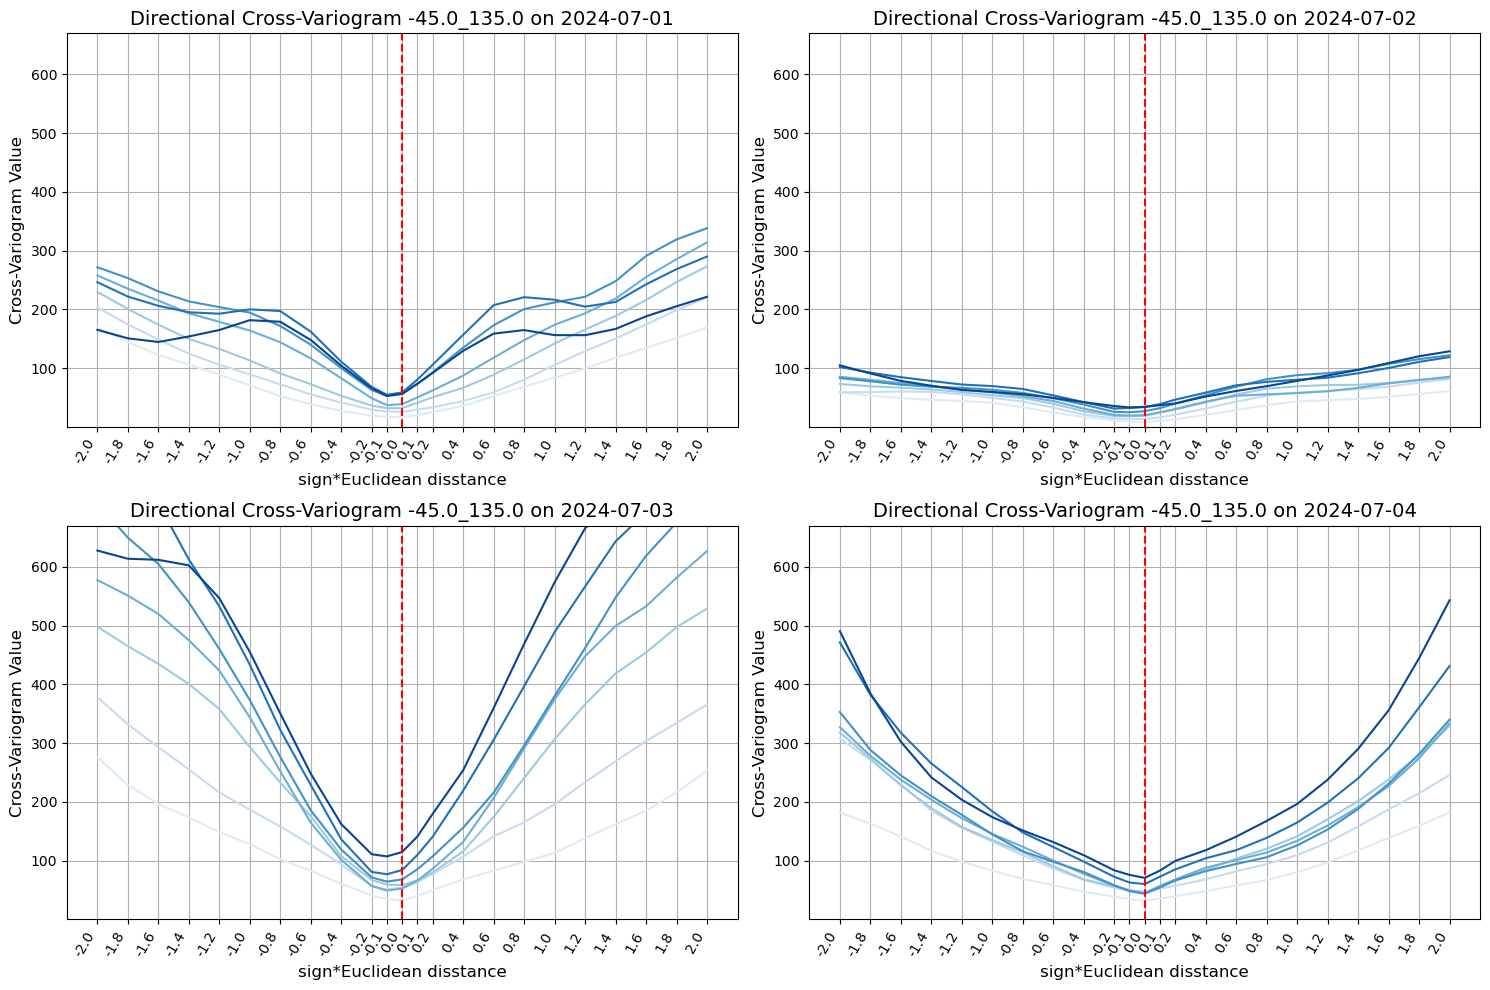

In [ ]:
save_path = config.mac_save_semivariogram_path
smooth = 0.5
length_of_analysis = f'whole day smooth {smooth:0.1f}'
instance_sem = evaluate.CrossVariogram_empirical(save_path, length_of_analysis,smooth)


# x_values = [-1, -.8, -.6, -.4, -.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
dayss = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20], [21,22,23,24], [25,26,27,28], [29,30,31]]
tmp = np.concatenate((np.linspace(-2, -0.2, 10), [-0.1, 0, 0.1], np.linspace(0.2, 2, 10)))
dayss = [[1,2,3,4]]
for days in dayss:
    
    tolerance = 0.02

    # latitude direction
    lat_lags = [ (round(a,1),0 ) for a in tmp]
    instance_sem.plot_lat_empirical( cross_lat_18000,days, lat_lags)

    # longitude direction
    lon_lags = [ (0, round(a,1)) for a in tmp]
    instance_sem.plot_lon_empirical( cross_lon_18000,days,lon_lags)

'''
    tolerance = 0.02
    d45 = np.arctan2(1,1)
    d135 = np.arctan2(-1,-1)  

    # y=x direction
    instance_sem.plot_directional_sem_empirical(tmp, d135_45_20000, days, d135, d45)

    # y=-x direction
    dn45 = np.arctan2(-1,1)
    dn135 = np.arctan2(1,-1)
    instance_sem.plot_directional_sem_empirical(tmp, dn45_n135_20000, days, dn45, dn135)
'''

### which hours are important?

In [ ]:
ssdf = d_lon_20000
res = [] 

for j in range(1, len(ssdf)):
    tmp = []
    sdf = d_lon_20000[j]
    for i in range(len(sdf)-1):
        # print(f'correlation between {i} and {i+1} in day {j} {np.corrcoef( sdf[i], sdf[i+1])}' )
        tmp.append( np.corrcoef( sdf[i], sdf[i+1])[0][1] )
    min_correlation_index = np.argmax(tmp)
    res.append(min_correlation_index)


plt.hist(res, bins=range(min(res), max(res) + 2), edgecolor='black', align='left')
plt.xlabel('Index of Maximum Correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Index of Maximum Correlation')
plt.xticks(range(min(res), max(res) + 1))
plt.show()